In [6]:
# main.py

import os
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, Subset
from ase import io
import matplotlib.pyplot as plt

from PyISV.network_2D_classification import Classifier2D
from PyISV.train_utils_classification import ClassificationTrainer
from PyISV.train_utils_classification import MultiFrameRDFImageDataset


In [ ]:
# —————————————————————————————————————————————
# 1) Configuration (paths, hyperparameters)
# —————————————————————————————————————————————

XYZ_PATH   = "/Users/frasera/Ricerca/PyISV/structures/full_min_ptmd_m18_nCu_0.xyz"
LABEL_FILE = "/Users/frasera/Ricerca/PyISV/Ag38_labels/isv_labels_2D_nonMin_to_min_k15_nCu_0.txt"

N_BINS     = 64
R_MAX      = 10.0
BANDWIDTH  = 0.1

NUM_CLASSES        = 14
NUM_FINAL_CHANNELS = 16
EMBED_DIM          = 128
LR                 = 1e-3
WEIGHT_DECAY       = 1e-5
BATCH_SIZE         = 32
NUM_EPOCHS         = 50
VAL_SPLIT          = 0.2
DEVICE             = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
# —————————————————————————————————————————————
# 1) Configuration for TESTING
# —————————————————————————————————————————————

XYZ_PATH   = "/Users/frasera/Ricerca/PyISV/structures/full_min_ptmd_m18_nCu_0.xyz"
LABEL_FILE = "Ag38_labels/isv_labels_2D_nonMin_to_min_k15_nCu_0.txt"

N_BINS     = 32          # fewer bins: faster RDF and smaller images (32x32 instead of 64x64)
R_MAX      = 8.0         # slightly smaller max distance for RDF
BANDWIDTH  = 0.15        # slightly wider smoothing to make RDF curves smoother

NUM_CLASSES        = 6
NUM_FINAL_CHANNELS = 8   # fewer channels: lighter encoder
EMBED_DIM          = 64  # smaller embedding
LR                 = 1e-3
WEIGHT_DECAY       = 0   # no weight decay for simple runs
BATCH_SIZE         = 32  # larger batch size if memory allows (fewer optimizer steps)
NUM_EPOCHS         = 5   # just 5 epochs to see if training works
VAL_SPLIT          = 0.3 # slightly larger validation split to check overfitting
DEVICE             = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
# —————————————————————————————————————————————
# 2) Prepare bins & bandwidth tensors
# —————————————————————————————————————————————
bins_tensor      = torch.linspace(0.0, R_MAX, steps=N_BINS)
bandwidth_tensor = torch.full((N_BINS,), BANDWIDTH)

# —————————————————————————————————————————————
# 3) Read labels
# —————————————————————————————————————————————
labels = torch.LongTensor(np.loadtxt(LABEL_FILE, dtype=int))
assert labels.ndim == 1, "Labels must be a 1D array"

# —————————————————————————————————————————————
# 4) Multi‐frame dataset for single XYZ file
# —————————————————————————————————————————————

# instantiate
full_dataset = MultiFrameRDFImageDataset(XYZ_PATH, labels, bins_tensor, bandwidth_tensor)


In [ ]:
indices = list(range(0, len(full_dataset), 10))
work_dataset = Subset(full_dataset, indices)


7200


Text(0, 0.5, 'g(r)')

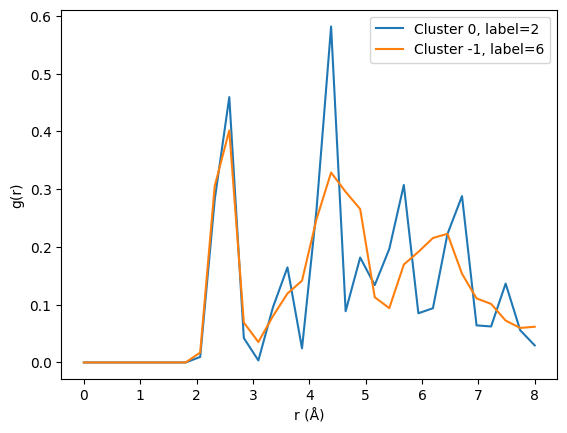

In [11]:
import matplotlib.pyplot as plt

plt.figure()
for i in [0,-1]:
    img, lbl = work_dataset[i]       # img: tensor shape [1, H, W]
    rdf = img[0, 0, :].cpu().numpy() # take first row across W
    plt.plot(bins_tensor.numpy(), rdf, label=f'Cluster {i}, label={lbl}')
plt.legend(); plt.xlabel('r (Å)'); plt.ylabel('g(r)')


In [12]:
# —————————————————————————————————————————————
# 5) Split & loaders
# —————————————————————————————————————————————
val_size   = int(VAL_SPLIT * len(work_dataset))
train_size = len(work_dataset) - val_size
train_ds, val_ds = random_split(work_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

In [14]:
# —————————————————————————————————————————————
# 6) Model & trainer
# —————————————————————————————————————————————
spatial_size = N_BINS // 4
flat_dim     = NUM_FINAL_CHANNELS * spatial_size * spatial_size

model = Classifier2D(
    embed_dim                  = EMBED_DIM,
    flat_dim                   = flat_dim,
    num_classes                = NUM_CLASSES,
    num_encoder_final_channels = NUM_FINAL_CHANNELS
)

trainer = ClassificationTrainer(
    model        = model,
    train_loader = train_loader,
    val_loader   = val_loader,
    lr           = LR,
    weight_decay = WEIGHT_DECAY,
    device       = DEVICE
)


In [15]:
from tqdm import tqdm

# —————————————————————————————————————————————
# 7) Training loop
# —————————————————————————————————————————————
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    train_loss, train_acc = trainer.train_epoch()
    val_loss,   val_acc   = trainer.validate_epoch()
    print(f"Epoch {epoch:02d} | "
          f"Train L={train_loss:.4f}, A={train_acc:.4f} | "
          f"Val   L={val_loss:.4f}, A={val_acc:.4f}")


  0%|          | 0/5 [01:35<?, ?it/s]
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1100b8050>>
Traceback (most recent call last):
  File "/Users/frasera/Ricerca/PyISV/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
    def _clean_thread_parent_frames(

  File "/Users/frasera/Ricerca/PyISV/.venv/lib/python3.11/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 92959) is killed by signal: Abort 

KeyboardInterrupt: 